In [3]:
import os
import nltk
import json
import random
import string
import requests
import spacy as sp
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from sklearn import metrics
from itertools import groupby
from collections import Counter
from nltk.collocations import *
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.pyplot import figure
from sklearn.model_selection import KFold
from nltk import word_tokenize as tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
data = pd.read_csv('/media/hector/DATA/datalab-data/altmetrics_j2018_full.csv')

In [ ]:
# take 1% fraction
data = data.sample(frac=0.01, random_state=2018).reset_index(drop=True)

# reset the index once again
data = data.sample(frac=1, random_state=2018).reset_index(drop=True)

# print the head of the dataset
data.head()

In [4]:
# data.to_csv("sampled_dataset_beta.csv", sep = ',', encoding="utf-8")
data = pd.read_csv('sampled_dataset_charlie.csv', index_col=0)

# print head
data.head()

,title,abstract,blog_post,similarity_score,yules_i_for_abs,avg_word_len_abs,avg_sen_len_abs,freq_of_words_great_sent_len_abs,mendeley_readers,citeulikereaders,...,altmetric_score_6m,altmetric_score_3m,altmetric_score_1m,altmetric_score_1w,altmetric_score_6d,altmetric_score_5d,altmetric_score_4d,altmetric_score_3d,altmetric_score_3d.1,altmetric_score_1d
altmetric_id,,,,,,,,,,,,,,,,,,,,,
2340452,Hydrogel Bioprinted Microchannel Networks for ...,Vascularization remains a critical challenge i...,Scientists use 3D printing to successfully add...,0.062027,30.970588,7.005128,194.125000,93,231,0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2884934,H63D HFE genotype accelerates disease progress...,H63D HFE is associated with iron dyshomeostasi...,Transgenic mice carrying a gene variant found ...,0.170682,15.113127,6.085714,156.818182,100,10,0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
137217,Importance of pollinators in changing landscap...,The extent of our reliance on animal pollinati...,We have a new PrePrint up at the peerJ (note t...,0.265519,15.810219,5.593074,216.571429,93,1792,4,...,282.08,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
118537,A Stem Cell Molecular Signature,Mechanisms regulating self-renewal and cell fa...,"Yesterday, a new paper in Nature from Ihor Lem...",0.147733,14.613527,5.782609,123.800000,41,19,6,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2989790,Mendelian randomisation applied to drug develo...,Despite increased expenditure productivity of ...,Observational epidemiology has implicated a wi...,0.151497,19.031532,5.637405,172.900000,124,1,0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [5]:
data.columns

Index(['altmetric_id', 'mendeley_readers', 'citeulikereaders',
       'connoteareaders', 'blog_users', 'blogs_posts_count',
       'news_unique_users', 'total_posts_count', 'wiki_posts_count',
       'facebook_users', 'facebook_posts', 'twitter_users', 'twitter_posts',
       'citation_page', 'other_articles', 'mean', 'rank', 'perc',
       'scored_higher_than', 'sample_size', 'users_lecturer',
       'users_librarian', 'users_student_bachelor', 'users_student_master',
       'users_student_pg', 'users_student_phd', 'users_student_doct',
       'users_researcher', 'users_other', 'users_prof_assoc', 'users_prof',
       'users_medi', 'users_ss', 'users_psych', 'users_earth', 'users_agri',
       'users_arts', 'users_us', 'users_th', 'users_ie', 'users_id',
       'users_au', 'users_gb', 'altmetric_score', 'altmetric_score_1y',
       'altmetric_score_6m', 'altmetric_score_3m', 'altmetric_score_1m',
       'altmetric_score_1w', 'altmetric_score_6d', 'altmetric_score_5d',
       'altmetri

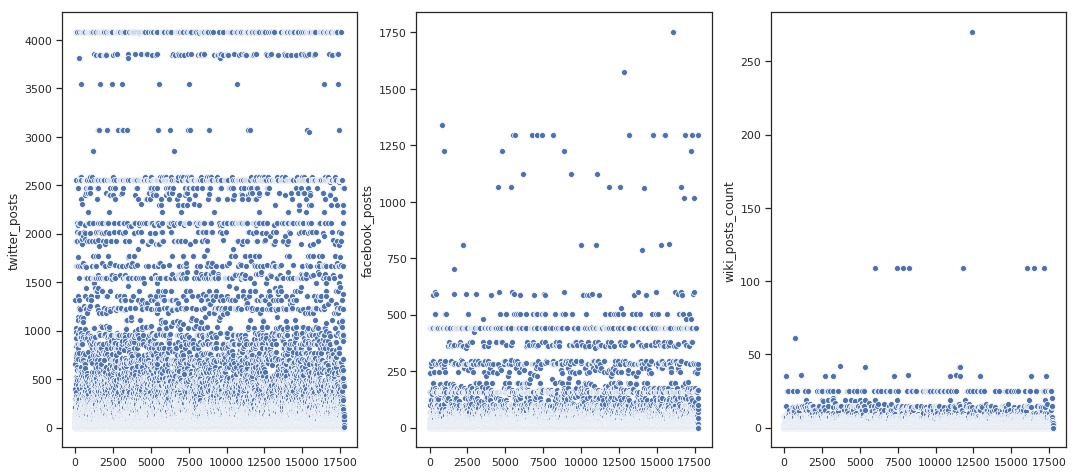

In [14]:
# set the sns style as ticks
sns.set(style='ticks')

# create the figure and axes for the subplot
f, axes = plt.subplots(1, 3, figsize=(18,8))

# load the scatterplot matrix for the 3 month target variable
sns.scatterplot(y='twitter_posts', x=list(range(len(data))) ,data=data, ax=axes[0])

# load the scatter plot matrix for the 6 months target variable
sns.scatterplot(y='facebook_posts', x=list(range(len(data))) ,data=data, ax=axes[1])

# load the scatter plot matrix for the 1 year target variable
sns.scatterplot(y='wiki_posts_count', x=list(range(len(data))) ,data=data, ax=axes[2])

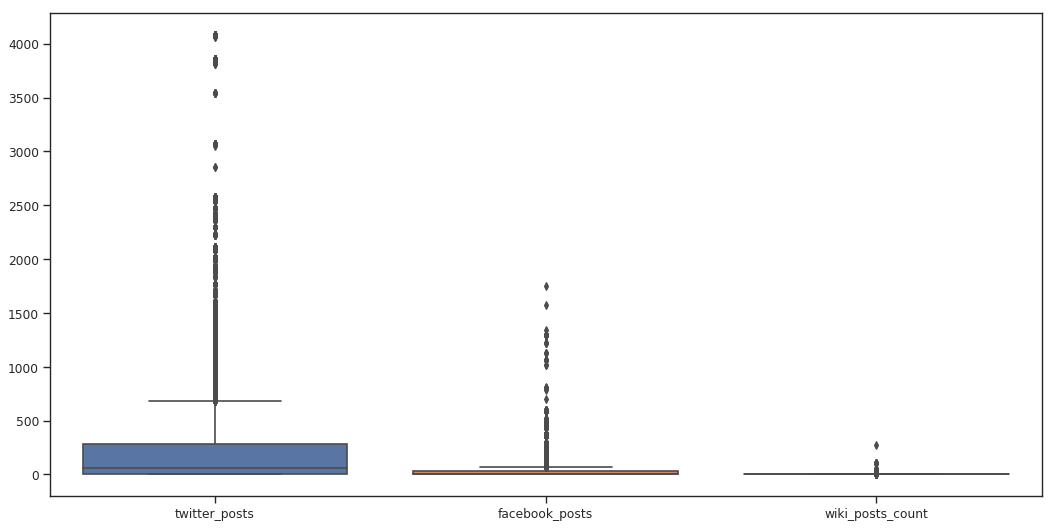

In [15]:
plt.figure(num=None, figsize=(16, 8), dpi=80, facecolor='w', edgecolor='k')

# create a boxplot for all the features
sns.boxplot(data=data.iloc[:, [
    data.columns.get_loc('twitter_posts'),
    data.columns.get_loc('facebook_posts'),
    data.columns.get_loc('wiki_posts_count')]])

In [8]:
# function for calculating words in a sentence
def words_in_sentence(sentence):
    w = [words.strip("0123456789!:,.?()[]{}") for words in sentence.split()]
    return filter(lambda x: len(x) > 0, w)

# function for computing yules i measure
def compute_yules_i_for_text(sentence):
    dictionary = {}
    stemmer = PorterStemmer()

    for word in words_in_sentence(sentence):
        word = stemmer.stem(word).lower()
        try:
            dictionary[word] += 1
        except:
            dictionary[word] = 1

    m1 = float(len(dictionary))
    m2 = sum([len(list(grouped_values)) * (frequency ** 2) for frequency, grouped_values in groupby(sorted(dictionary.values()))])

    # compute yules i and return the value
    try:
        yules_i = (m1 * m1) / (m2 - m1)
        return yules_i
    except ZeroDivisionError:
        return 0

# function for calculating trigrams and bigrams
def compute_collocation_score(sentence_one, sentence_two, option):
    if option == "bi":
        tokens_for_one = nltk.wordpunct_tokenize(sentence_one)
        tokens_for_two = nltk.wordpunct_tokenize(sentence_two)
        finder_one = BigramCollocationFinder.from_words(tokens_for_one)
        finder_two = BigramCollocationFinder.from_words(tokens_for_two)
        result_one = finder_one.score_ngrams(nltk.collocations.BigramAssocMeasures().raw_freq)
        result_one = [(tuple(map(str.lower, values)), scores) for values, scores in result_one]
        result_two = finder_two.score_ngrams(nltk.collocations.BigramAssocMeasures().raw_freq)
        result_two = [(tuple(map(str.lower, values)), scores) for values, scores in result_two]
        matches = [keys for keys in set(result_one).intersection(set(result_two))]
        return len(matches)
    elif option == "tri":
        tokens_for_one = nltk.wordpunct_tokenize(sentence_one)
        tokens_for_two = nltk.wordpunct_tokenize(sentence_two)
        finder_one = TrigramCollocationFinder.from_words(tokens_for_one)
        finder_two = TrigramCollocationFinder.from_words(tokens_for_two)
        result_one = finder_one.score_ngrams(nltk.collocations.TrigramAssocMeasures().raw_freq)
        result_one = [(tuple(map(str.lower, values)), scores) for values, scores in result_one]
        result_two = finder_two.score_ngrams(nltk.collocations.TrigramAssocMeasures().raw_freq)
        result_two = [(tuple(map(str.lower, values)), scores) for values, scores in result_two]
        matches = [keys for keys in set(result_one).intersection(set(result_two))]
        return len(matches)
    else:
        return 0

def compute_average_word_length(sentence):
    return np.mean([len(words) for words in sentence.split()])

def compute_average_sentence_length(sentence):
    sentence = re.split("(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s", sentence)
    return np.mean([len(words) for words in sentence])

def freq_of_words_great_sent_len(sentence):
    result = []
    avg_word_len = compute_average_word_length(sentence)
    # sentence = re.split("(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s", sentence)
    sentence = Counter(sentence.split())
    for key, value in sentence.items():
        if len(key) > avg_word_len:
            result.append(value)
#             print (key, value)
    return sum(result)    

# function for removing stop words from a sentence
def remove_stopwords(text):
    stemmer =  PorterStemmer()
    stopwords = nltk.corpus.stopwords.words('english')
    content = [w for w in [stemmer.stem(words) for words in tokenize(text)] if w.lower() not in stopwords]
    return content

# function for calculating cosine similarity for a given pair of sentences
def cosine_sim(sentence_a, sentence_b):
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(tuple([' '.join(remove_stopwords(sentence_a))]) + tuple([' '.join(remove_stopwords(sentence_b))]))
    return cosine_similarity(tfidf_matrix[0:1], tfidf_matrix)[0][1]

# add title of the scholarly paper
def add_title(alt_id):
    response = requests.get("https://api.altmetric.com/v1/id/" + str(alt_id))
    if 'title' in dict(json.loads(response.content)):
        return dict(json.loads(response.content))['title']
    else:
        return ''

# add abstract of the scholarly paper
def add_abs(alt_id):
    response = requests.get("https://api.altmetric.com/v1/id/" + str(alt_id))
    if 'abstract' in dict(json.loads(response.content)):
        return dict(json.loads(response.content))['abstract']
    else:
        return ''

# add author count of the scholarly paper
def add_author_count(alt_id):
    response = requests.get("https://api.altmetric.com/v1/id/" + str(alt_id))
    return len(dict(json.loads(response.content))['authors'])

# add doi of the scholarly paper
def add_doi(alt_id):
    response = requests.get("https://api.altmetric.com/v1/id/" + str(alt_id))
    return dict(json.loads(response.content))['doi']

In [9]:
add_doi(data['altmetric_id'][0])

'10.1007/s00038-011-0266-4'

In [10]:
len(data)

20041

In [ ]:
# add the column abstract
data = data.assign(abstract = 
            [add_abs(x) for x in tqdm(data['altmetric_id'])])

# add the column title
data = data.assign(title = 
            [add_title(x) for x in tqdm(data['altmetric_id'])])

# add the column authour count
data = data.assign(auth_count = 
            [add_author_count(x) for x in tqdm(data['altmetric_id'])])

# add the column yules I for text a
data = data.assign(yules_i_abs = 
            [compute_yules_i_for_text(x) for x in tqdm(data['abstract'])])

# add the column avg word len
data = data.assign(avg_word_len_abs = 
            [compute_average_word_length(data["abstract"][each]) for each in range(0, len(data["altmetric_id"]))])

# add the column avg sen len
data = data.assign(avg_sen_len_abs = 
            [compute_average_sentence_length(data["abstract"][each]) for each in range(0, len(data["altmetric_id"]))])

# add the column fwgawl
data = data.assign(freq_of_words_great_sent_len_abs = 
            [freq_of_words_great_sent_len(data["abstract"][each]) for each in range(0, len(data["altmetric_id"]))])

# add the column bi grams for (text_a, text_b)
data = data.assign(bigrams = 
            [compute_collocation_score(data['abstract'][x], data['title'][x], 'bi')
             for x in tqdm(range(len(data)))])

# add the column tri grams for (text_a, text_b)
data = data.assign(trigrams = 
            [compute_collocation_score(data['abstract'][x], data['title'][x], 'tri')
             for x in tqdm(range(len(data)))])

# add the cosine similarity between a and b
data = data.assign(cos_sim = 
            [cosine_sim(data['abstract'][x], data['title'][x])
             for x in tqdm(range(len(data)))])

# display the head of the training data
data.head()

In [5]:
train = data.sample(frac = 0.8, random_state = 2019)
test = data.loc[~data.index.isin(train.index)]

In [6]:
data_columns = [
    data.columns.get_loc('similarity_score'),
    data.columns.get_loc('yules_i_for_abs'),
    data.columns.get_loc('avg_word_len_abs'),
    data.columns.get_loc('avg_sen_len_abs'),
    data.columns.get_loc('freq_of_words_great_sent_len_abs'),
    data.columns.get_loc('blogs_posts_count'),
    data.columns.get_loc('blog_users'),
    data.columns.get_loc('mendeley_readers')]

In [7]:
data_columns

[3, 4, 5, 6, 7, 12, 11, 8]

In [8]:
# x_train, x_test, y_train, y_test
train_data_array = train.iloc[:, data_columns].values
train_class_array = train['twitter_posts'].values
test_data_array = test.iloc[:, data_columns].values
test_class_array = test['twitter_posts'].values

In [9]:
# Random Forest classifier
rf = RandomForestRegressor()

# 10 fold validation split
kf = KFold(n_splits=10, random_state = 42, shuffle=False)
val_errors = []
train_errors = []

# test train split
for train_index, val_index in kf.split(train_data_array):
    X_train, X_val = train_data_array[train_index], train_data_array[val_index]
    y_train, y_val = train_class_array[train_index], train_class_array[val_index]
    rf.fit(X_train, y_train)
    val_pred = rf.predict(X_val)
    train_pred = rf.predict(X_train)
    val_errors.append(metrics.mean_squared_error(y_val, val_pred))
    train_errors.append(metrics.mean_squared_error(y_train, train_pred))

# train again on the entire data
rf.fit(train_data_array, train_class_array)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [26]:
pd.DataFrame(rf.feature_importances_)

,0
0,0.002655
1,0.032782
2,0.023732
3,0.048408
4,0.057881
5,0.021016
6,0.764554
7,0.048972


In [30]:
# Mean in sample accuracy score with 95% CI
score = cross_val_score(rf, X_train, y_train, cv=5)
print("training mse: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

# Mean out of sample accuracy score with 95% CI
score = cross_val_score(rf, X_val, y_val, cv=5)
print("test mse: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

# r-squared
# train again on the entire data
r2 = rf.score(X_val, y_val)
print("r-squared mse: %0.2f" % (r2))

training mse: 0.97 (+/- 0.02)
test mse: 0.87 (+/- 0.07)
r-squared mse: 1.00


In [10]:
from sklearn.neighbors import KNeighborsRegressor

# knn
knn = KNeighborsRegressor()

# 10 fold validation split
kf = KFold(n_splits=10, random_state = 42, shuffle=False)
val_errors = []
train_errors = []

# test train split
for train_index, val_index in kf.split(train_data_array):
    X_train, X_val = train_data_array[train_index], train_data_array[val_index]
    y_train, y_val = train_class_array[train_index], train_class_array[val_index]
    knn.fit(X_train, y_train)
    val_pred = knn.predict(X_val)
    train_pred = knn.predict(X_train)
    val_errors.append(metrics.mean_squared_error(y_val, val_pred))
    train_errors.append(metrics.mean_squared_error(y_train, train_pred))

# train again on the entire data
knn.fit(train_data_array, train_class_array)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [11]:
# Mean in sample accuracy score with 95% CI
score = cross_val_score(rf, X_train, y_train, cv=5)
print("training mse: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

# Mean out of sample accuracy score with 95% CI
score = cross_val_score(rf, X_val, y_val, cv=5)
print("test mse: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

# r-squared
# train again on the entire data
r2 = knn.score(X_val, y_val)
print("r-squared mse: %0.2f" % (r2))

training mse: 0.97 (+/- 0.01)
test mse: 0.87 (+/- 0.06)
r-squared mse: 0.98


In [20]:
from sklearn.tree import DecisionTreeRegressor

# knn
dt = DecisionTreeRegressor()

# 10 fold validation split
kf = KFold(n_splits=10, random_state = 42, shuffle=False)
val_errors = []
train_errors = []

# test train split
for train_index, val_index in kf.split(train_data_array):
    X_train, X_val = train_data_array[train_index], train_data_array[val_index]
    y_train, y_val = train_class_array[train_index], train_class_array[val_index]
    dt.fit(X_train, y_train)
    val_pred = dt.predict(X_val)
    train_pred = dt.predict(X_train)
    val_errors.append(metrics.mean_squared_error(y_val, val_pred))
    train_errors.append(metrics.mean_squared_error(y_train, train_pred))

# train again on the entire data
dt.fit(train_data_array, train_class_array)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [21]:
# Mean in sample accuracy score with 95% CI
score = cross_val_score(rf, X_train, y_train, cv=5)
print("training mse: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

# Mean out of sample accuracy score with 95% CI
score = cross_val_score(rf, X_val, y_val, cv=5)
print("test mse: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

# r-squared
# train again on the entire data
r2 = dt.score(X_val, y_val)
print("r-squared mse: %0.2f" % (r2))

training mse: 0.97 (+/- 0.02)
test mse: 0.88 (+/- 0.04)
r-squared mse: 1.00


In [18]:
train.iloc[:, data_columns].corr()

,similarity_score,yules_i_for_abs,avg_word_len_abs,avg_sen_len_abs,freq_of_words_great_sent_len_abs,blogs_posts_count,blog_users,mendeley_readers
similarity_score,1.000000,-0.035249,-0.016756,-0.010501,0.064249,-0.066219,-0.057758,-0.032578
yules_i_for_abs,-0.035249,1.000000,0.120829,-0.066573,-0.376830,-0.103513,-0.093893,-0.039193
avg_word_len_abs,-0.016756,0.120829,1.000000,0.067038,-0.073843,-0.021092,-0.004211,-0.052702
avg_sen_len_abs,-0.010501,-0.066573,0.067038,1.000000,0.252423,0.086744,0.081167,0.038193
freq_of_words_great_sent_len_abs,0.064249,-0.376830,-0.073843,0.252423,1.000000,0.077793,0.091728,0.006059
blogs_posts_count,-0.066219,-0.103513,-0.021092,0.086744,0.077793,1.000000,0.980618,0.507140
blog_users,-0.057758,-0.093893,-0.004211,0.081167,0.091728,0.980618,1.000000,0.464988
mendeley_readers,-0.032578,-0.039193,-0.052702,0.038193,0.006059,0.507140,0.464988,1.000000


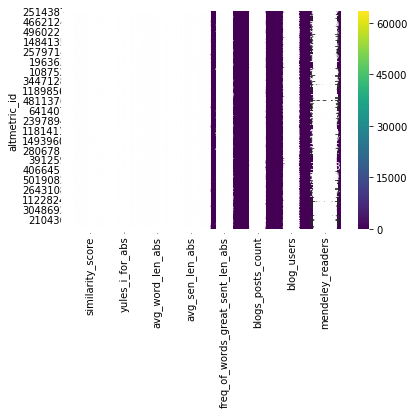

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(train.iloc[:, data_columns], annot=True, fmt="g", cmap='viridis')
plt.show()